**WORKS FOR EVERYTHING APART FROM THE DISTANCE CALCULATIONS (BUT we DONT ACTUALLY NEED THOSE, JUST FOR PLOT)**

### 1. Load Packages

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gp
import pandas as pd

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta as delta
from operator import attrgetter

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

OFES data was in cm/s NOT in m/s!!!!

In [2]:
df = pd.read_csv('C:\\Users\\sandr\\Documents\\Github\\ThesisSandra\\Analysis\\Movement\\Data\\oceanCellsBOATS.csv', header=None)
df = df.rename(columns={df.columns[0]: 'lon', df.columns[1]: 'lat'}).drop(df.columns[2], axis=1)
df.lon = df.lon+180

In [3]:
df2 = df[df.lat < (-40)] #-32
df3 = df2[df2.lat >(-43)] #-38
df4 = df3[df3.lon >358]
# df5 = df4[df4.lon <4] #27

In [4]:
df4

,lon,lat
10701,358.5,-42.5
10702,359.5,-42.5
11042,358.5,-41.5
11043,359.5,-41.5
11386,358.5,-40.5
11387,359.5,-40.5


In [5]:
df6 = df3[df3.lon <1] #27

In [6]:
df6

,lon,lat
10361,0.5,-42.5
10703,0.5,-41.5
11044,0.5,-40.5


In [7]:
frames = [df4, df6]
df5 = pd.concat(frames)

In [8]:
df5

,lon,lat
10701,358.5,-42.5
10702,359.5,-42.5
11042,358.5,-41.5
11043,359.5,-41.5
11386,358.5,-40.5
11387,359.5,-40.5
10361,0.5,-42.5
10703,0.5,-41.5
11044,0.5,-40.5


In [9]:
StartLocations = df5.reset_index(drop=True)       
for i in np.arange(0, len(StartLocations)):
    lonVals = np.linspace(StartLocations.lon[i]-0.45, StartLocations.lon[i]+0.45, 10) #to get even steps between released particles within and between cells (released every 0.1°)
    latVals = np.linspace(StartLocations.lat[i]-0.45, StartLocations.lat[i]+0.45, 10)
    #print(i)
    
    for j in np.arange(0, len(lonVals)):
        lonRep = np.repeat(lonVals[j], 10)
        partRelease = pd.concat([pd.DataFrame({"lon": lonRep}), pd.DataFrame({"lat":latVals})], axis=1)
        if i == 0 and j == 0:
            StartLoc = partRelease
        else:
            StartLoc = pd.concat([StartLoc, partRelease])
StartLoc

,lon,lat
0,358.05,-42.95
1,358.05,-42.85
2,358.05,-42.75
3,358.05,-42.65
4,358.05,-42.55
...,...,...
5,0.95,-40.45
6,0.95,-40.35
7,0.95,-40.25
8,0.95,-40.15


In [10]:
StartLoc.reset_index(drop=True)[550:610]

,lon,lat
550,359.55,-40.95
551,359.55,-40.85
552,359.55,-40.75
553,359.55,-40.65
554,359.55,-40.55
555,359.55,-40.45
556,359.55,-40.35
557,359.55,-40.25
558,359.55,-40.15
559,359.55,-40.05


### 2. Specify Data Location and Filenames

In [11]:
dataPath = "C:\\Users\\sandr\\Documents\\Github\ThesisSandra\\Analysis\\Movement\\TracerDataAndOutput\\OFES\\"
ufiles = dataPath + "OfESncep01globalmmeanuMS.nc"
vfiles = dataPath + "OfESncep01globalmmeanvMS.nc"

filenames = {'U': ufiles,
             'V': vfiles}

variables = {'U': 'uvel',
             'V': 'vvel'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

### 3. Define Fieldset

In [12]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.add_constant('maxage', 1.*86400) #get rid of particles after 4 days

In [13]:
fieldset.add_periodic_halo(zonal=True)

In [14]:
fieldset.U.lon[1] -fieldset.U.lon[0]

0.1

In [15]:
fieldset.U.lon[1]

0.1

In [16]:
fieldset.U.lon[-1] -fieldset.U.lon[-2]

0.1000061

In [17]:
fieldset.U.lon[-2]

359.8

In [18]:
fieldset.U.lon[-1]

359.9

### 4. Define Simulation Conditions

In [19]:
#npartNumber = len(StartLoc) #release Locations

lon_array = StartLoc.lon #[357.9, 358.9, 359.9, 0.9, 1.9, 2.9]
lat_array = StartLoc.lat #[-41, -41.5, -42, -42.5, -43, -43.5]

#lon_array = np.linspace(140, 141, num=npartNumber)
#lat_array = np.linspace(5, 6, num=npartNumber)
# time = np.arange(0, npart) * delta(hours=2).total_seconds()  # release every particle two hours later

In [20]:
npart = 1 #how many particles are released at each location (every time)
lon = np.repeat(lon_array, npart)
lat = np.repeat(lat_array, npart)

# How often to release the particles
repeatdt = None #delta(days = 1) # release from the same set of locations every X day

#runtime = end_time-start_time + delta(days=1) #for later
runtime = delta(days=1) #how long is total runtime (how long each individual tracer is tracked i defined by maxage)

# Define when you want tracking to start (i.e. start of the spawning season)
#pset_start = (start_time-datetime.strptime(str(fieldset.time_origin)[0:10], "%Y-%m-%d")).total_seconds()
# Create an array of release times 
#release_times = pset_start + (np.arange(0, runtime.days) * repeatdt.total_seconds())  
# Multiply the release times by the number of particles
#time = np.repeat(release_times, npart)

time = 0 #np.arange(0, npart) * delta(days = 1).total_seconds() #Here: to only release at beginning of data: = 0
time

0

In [21]:
len(lon_array)

900

### 5. Define Particle Properties

In [22]:
class SampleParticle(JITParticle):         # Define a new particle class
        sampled = Variable('sampled', dtype = np.float32, initial = 0, to_write=False)
        age = Variable('age', dtype=np.float32, initial=0.) # initialise age
        distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
        prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                            initial=0)  # the previous longitude
        prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                            initial=0)  # the previous latitude
        #u_vel = Variable('u_vel', dtype = np.float32, initial = 0)
        #v_vel = Variable('v_vel', dtype = np.float32, initial = 0)
        #beached = Variable('beached', dtype = np.float32, initial = 0)
    
def DeleteParticle(particle, fieldset, time): #needed to avoid error mesasage of Particle out of bounds
    particle.delete()
    
# Define all the sampling kernels
# def SampleDistance(particle, fieldset, time):
#     # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
#     lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
#     # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    
#     if particle.lon > 359: #(particle.lon - particle.prev_lon) < (-300):
# #         lon_temp = particle.lon -180
# #         prev_lon_temp = particle.prev_lon -180
# #         lon_dist = (lon_temp - prev_lon_temp) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
#         # Calculate the total Euclidean distance travelled by the particle
#         particle.distance += 300 #math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))
#         particle.prev_lon = particle.lon  # Set the stored values for next iteration.
#         particle.prev_lat = particle.lat
        
#     else:
#         lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
#         # Calculate the total Euclidean distance travelled by the particle
#         particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))
#         particle.prev_lon = particle.lon  # Set the stored values for next iteration.
#         particle.prev_lat = particle.lat

def SampleDistance(particle, fieldset, time):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))
    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

def SampleAge(particle, fieldset, time):
    particle.age = particle.age + math.fabs(particle.dt)
    if particle.age > fieldset.maxage:
           particle.delete()
            
def periodicBC(particle, fieldset, time):
    if particle.lon < 0:
        particle.lon += 360 - 0
    elif particle.lon > 359.9:
        particle.lon -= 360 - 0
    
def SampleInitial(particle, fieldset, time): # do we have to add particle.age and particle.ageRise
        if particle.sampled == 0:
            particle.distance = particle.distance
            particle.prev_lon = particle.lon
            particle.prev_lat = particle.lat
            #particle.u_vel = fieldset.U[time, particle.depth, particle.lat, particle.lon]
            #particle.v_vel = fieldset.V[time, particle.depth, particle.lat, particle.lon]
            #particle.beached = particle.beached
            particle.sampled = 1
               
pset = ParticleSet.from_list(fieldset, 
                             pclass=SampleParticle, 
                             time=time, 
                             lon=lon, 
                             lat=lat,
                             repeatdt=repeatdt)


In [23]:
kernels = SampleInitial + pset.Kernel(AdvectionRK4) + periodicBC + SampleAge + SampleDistance
#AdvectionRK4 + pset.Kernel(periodicBC) + SampleDistance
#SampleInitial + pset.Kernel(AdvectionRK4) + SampleAge + SampleDistance 

In [24]:
# pset = ParticleSet.from_list(fieldset, 
#                              pclass=DistParticle, 
#                              time=time, 
#                              lon=lon, 
#                              lat=lat,
#                              repeatdt=repeatdt)

In [25]:
output_nc_dist = 'ParcelsOutput\\CheckPrimeMeridian3.zarr'
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=delta(hours=1))

pset.execute(kernels,  # Add kernels using the + operator.
             runtime=runtime,
             dt=delta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


INFO: Compiled ArraySampleParticleSampleInitialAdvectionRK4periodicBCSampleAgeSampleDistance ==> C:\Users\sandr\AppData\Local\Temp\parcels-tmp\lib3a4fd5be8d5e609b842b58e2a2680d4d_0.dll


In [26]:
parcels_dist = xr.open_dataset(output_nc_dist)
parcels_dist

C:\Users\sandr\.conda\envs\py3_parcels3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\sandr\.conda\envs\py3_parcels3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:     (trajectory: 900, obs: 25)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 ... 893 894 895 896 897 898 899
Data variables:
    age         (trajectory, obs) float32 ...
    distance    (trajectory, obs) float32 ...
    lat         (trajectory, obs) float32 ...
    lon         (trajectory, obs) float32 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [27]:
TracerNumber = parcels_dist.distance.values.shape[0]
TotalDistance = []
for i in range(0, TracerNumber):
        distance = parcels_dist.distance.values
        maxDist = max(distance[i,])
        if maxDist > 1000000:
            maxDist = maxDist/1000000
        elif maxDist > 80000:
            maxDist = maxDist/10000
        TotalDistance.append(maxDist)
        #print(i)

TotalDistance

[5.3467245,
 5.120826,
 4.903257,
 4.74453,
 4.5478225,
 4.1613126,
 4.527943,
 5.582793,
 7.6072063,
 9.228212,
 5.59548,
 5.3441563,
 5.0662756,
 4.8496623,
 4.5394473,
 4.81808,
 5.1909575,
 6.5362077,
 8.513721,
 10.562651,
 5.398006,
 4.860473,
 4.601507,
 4.337733,
 4.4675727,
 4.900722,
 5.835919,
 7.6467466,
 9.589497,
 11.097645,
 5.2900887,
 4.8708897,
 4.595674,
 4.407426,
 4.2752266,
 4.9094934,
 6.3994308,
 8.091019,
 9.880806,
 11.484353,
 4.9038396,
 4.965905,
 4.5800123,
 4.4386373,
 4.3425,
 5.112204,
 6.9413757,
 8.498993,
 10.127116,
 11.662227,
 4.5889454,
 4.6829066,
 4.822761,
 4.613872,
 4.573181,
 4.958285,
 6.7705,
 8.664317,
 10.458272,
 11.803577,
 4.407707,
 4.476843,
 4.668522,
 4.81033,
 4.9669676,
 4.958489,
 6.2315626,
 8.416787,
 10.452687,
 11.705576,
 4.328824,
 4.360473,
 5.1320634,
 5.1809464,
 5.043521,
 5.052349,
 6.097687,
 7.8534327,
 10.17429,
 11.992544,
 4.301569,
 4.3118854,
 5.0474315,
 5.119215,
 5.3085074,
 5.421784,
 5.4205317,
 7.102139

In [28]:
TotalDistance25 = np.repeat(TotalDistance, 25).reshape(parcels_dist.distance.values.shape[0], 25)
parcels_dist['TotalDistance'] = (['trajectory', 'obs'],TotalDistance25)
parcels_dist

<xarray.Dataset>
Dimensions:        (trajectory: 900, obs: 25)
Coordinates:
  * obs            (obs) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * trajectory     (trajectory) int64 0 1 2 3 4 5 6 ... 894 895 896 897 898 899
Data variables:
    age            (trajectory, obs) float32 ...
    distance       (trajectory, obs) float32 0.0 0.2191 0.4382 ... 7.722 8.053
    lat            (trajectory, obs) float32 ...
    lon            (trajectory, obs) float32 ...
    time           (trajectory, obs) datetime64[ns] ...
    z              (trajectory, obs) float32 ...
    TotalDistance  (trajectory, obs) float64 5.347 5.347 5.347 ... 8.053 8.053
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

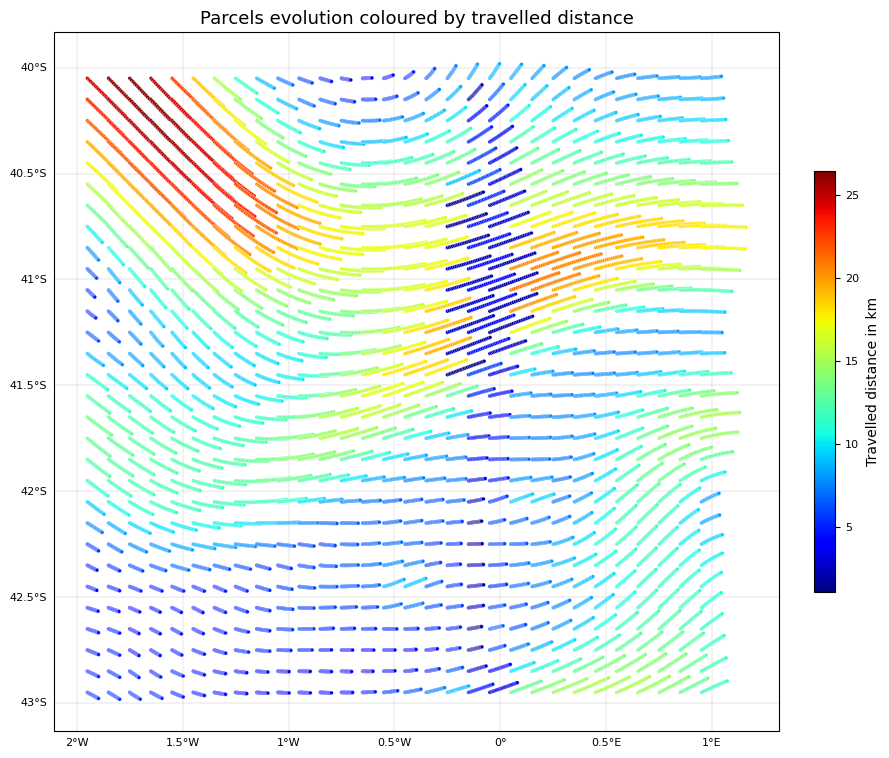

<Figure size 640x480 with 0 Axes>

In [29]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())


# Title
plt.title('Parcels evolution coloured by travelled distance',
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = min(TotalDistance)#parcels_dist.distance.min().item()
distmax = max(TotalDistance)#parcels_dist.distance.max().item()

for k in range(parcels_dist.lon.shape[0]):
    sc = plt.scatter(parcels_dist.lon.isel(trajectory=k), parcels_dist.lat.isel(trajectory=k), s=7, 
               c=parcels_dist.TotalDistance.isel(trajectory=k), edgecolors='w', 
               cmap='jet', vmin=distmin, vmax=distmax, 
               linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11) 

# Color bar
cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
cbar2.set_label('Travelled distance in km', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
fig.savefig('C:\\Users\\sandr\\Documents\\Github\\ThesisSandra\\Analysis\\Movement\\Figures\\ParticleTracking\\CheckPrimeMeridian3.png')
fig.clear()
plt.close(fig)
plt.clf()

Make plot (histogram), that shows how many particles move further than one grid cell (one further, two further, etc.)
For this: 
- assign indices to the centroids
- find the nearest neighbour centroid of BOATS for the time = 0 and assign them one of the centroid indices if they have the same starting centroid (i.e. started in same grid cell)
- find the nearest neighbour centroid at time = 24 (25?) and assign a centroid index
- loop through all the centroid indices and find out where the particles move to and count: how many stayed, how many moved to the 8 adjacent cells, how many to 16 adjacent cells (further than 8) etc and make histogram
- for those further than 8 adjacent cells (if not too many): how far did they go?



In [30]:
testdf = parcels_dist.to_dataframe().reset_index(drop=False) 
testdf.loc[testdf['TotalDistance'].idxmax()]

trajectory                       429
obs                                0
age                              0.0
distance                         0.0
lat                       -40.049999
lon                           358.25
time             2016-07-15 00:00:00
z                                0.0
TotalDistance              26.450191
Name: 10725, dtype: object

In [31]:
testdf[14960:15020]

,trajectory,obs,age,distance,lat,lon,time,z,TotalDistance
14960,598,10,36000.0,3.666076e+06,-40.119789,359.978973,2016-07-15 10:00:00,0.0,6.691815
14961,598,11,39600.0,4.032774e+06,-40.116768,359.981537,2016-07-15 11:00:00,0.0,6.691815
14962,598,12,43200.0,4.399486e+06,-40.113747,359.984100,2016-07-15 12:00:00,0.0,6.691815
14963,598,13,46800.0,4.766216e+06,-40.110725,359.986664,2016-07-15 13:00:00,0.0,6.691815
14964,598,14,50400.0,5.132962e+06,-40.107704,359.989227,2016-07-15 14:00:00,0.0,6.691815
14965,598,15,54000.0,5.499725e+06,-40.104683,359.991791,2016-07-15 15:00:00,0.0,6.691815
14966,598,16,57600.0,5.866504e+06,-40.101662,359.994354,2016-07-15 16:00:00,0.0,6.691815
14967,598,17,61200.0,6.233299e+06,-40.098640,359.996918,2016-07-15 17:00:00,0.0,6.691815
14968,598,18,64800.0,6.600110e+06,-40.095619,359.999481,2016-07-15 18:00:00,0.0,6.691815
14969,598,19,68400.0,6.691816e+06,-40.092628,0.002006,2016-07-15 19:00:00,0.0,6.691815


In [32]:
testdf2 = testdf[(testdf.obs == 24)|(testdf.obs == 0)].reset_index(drop=True) 
testdf2

,trajectory,obs,age,distance,lat,lon,time,z,TotalDistance
0,0,0,0.0,0.000000,-42.950001,358.049988,2016-07-15,0.0,5.346725
1,0,24,86400.0,5.346725,-42.978817,358.102722,2016-07-16,0.0,5.346725
2,1,0,0.0,0.000000,-42.849998,358.049988,2016-07-15,0.0,5.120826
3,1,24,86400.0,5.120826,-42.875172,358.102722,2016-07-16,0.0,5.120826
4,2,0,0.0,0.000000,-42.750000,358.049988,2016-07-15,0.0,4.903257
...,...,...,...,...,...,...,...,...,...
1795,897,24,86400.0,9.736556,-40.244560,1.064698,2016-07-16,0.0,9.736556
1796,898,0,0.0,0.000000,-40.150002,0.950000,2016-07-15,0.0,8.872452
1797,898,24,86400.0,8.872452,-40.143623,1.054217,2016-07-16,0.0,8.872452
1798,899,0,0.0,0.000000,-40.049999,0.950000,2016-07-15,0.0,8.052777


In [33]:
max(testdf2.TotalDistance)

26.450191497802734

In [34]:
testdf2.loc[testdf2['TotalDistance'].idxmax()]

trajectory                       429
obs                                0
age                              0.0
distance                         0.0
lat                       -40.049999
lon                           358.25
time             2016-07-15 00:00:00
z                                0.0
TotalDistance              26.450191
Name: 858, dtype: object

In [35]:
testdf2[1150:1210]

,trajectory,obs,age,distance,lat,lon,time,z,TotalDistance
1150,575,0,0.0,0.000000e+00,-40.450001,359.750000,2016-07-15,0.0,13.056454
1151,575,24,86400.0,1.305645e+01,-40.385902,359.879456,2016-07-16,0.0,13.056454
1152,576,0,0.0,0.000000e+00,-40.349998,359.750000,2016-07-15,0.0,11.636648
1153,576,24,86400.0,1.163665e+01,-40.286747,359.859528,2016-07-16,0.0,11.636648
1154,577,0,0.0,0.000000e+00,-40.250000,359.750000,2016-07-15,0.0,10.022951
1155,577,24,86400.0,1.002295e+01,-40.187866,359.835663,2016-07-16,0.0,10.022951
1156,578,0,0.0,0.000000e+00,-40.150002,359.750000,2016-07-15,0.0,8.619348
1157,578,24,86400.0,8.619348e+00,-40.089008,359.812622,2016-07-16,0.0,8.619348
1158,579,0,0.0,0.000000e+00,-40.049999,359.750000,2016-07-15,0.0,7.399023
1159,579,24,86400.0,7.399023e+00,-39.991077,359.790466,2016-07-16,0.0,7.399023
